In [1]:
import torch
import numpy as np
from utils.generate_csbm import *
from utils.train import *
from utils.utils import *
from models.models import *
from models.setup import *
import networkx as nx
import pickle

In [2]:
def exp_csbm(ith, method, folder_path, csbm, n_train, n_val, 
             num_communication=100, batch_size=1,
             learning_rate=0.01, I=10, gradient=True, noise=False,
             Print=False, print_time=1,
             resume=False,
             bias=False,
             save=True):
    

    init_mlp = MLP(csbm.Xs[0].shape[1], 64, 2, bias)
        
    if (gradient == False):
        grad = "no_grad/"
    elif (gradient == True and noise==False):
        grad = "biased_grad/"
    elif (gradient == True and noise==True):
        grad = "noisy_grad/"
      
    A_tilde = calculate_Atilde(csbm.A, K=10, alpha=0.9)
    server = set_up_GC(csbm.Xs, csbm.ys, init_mlp, A_tilde, n_train=n_train, n_val=n_val)
   
        
    tl, ta, vl, va = train_GC(server, num_communication, batch_size, learning_rate, I,
                              gradient, noise, 
                              Print, print_time)
    if save:    
        np.save(folder_path + method + grad + "I" + str(I) + "/tl_" + str(ith), tl)
        np.save(folder_path + method + grad + "I" + str(I) + "/ta_" + str(ith), ta)
        np.save(folder_path + method + grad + "I" + str(I) + "/vl_" + str(ith), vl)
        np.save(folder_path + method + grad + "I" + str(I) + "/va_" + str(ith), va)

        PATH = folder_path + method + grad + "I" + str(I) + "/model_" + str(ith)
        torch.save({
                'best_model_state_dict': server.best_cmodel.state_dict(),
                'learning_rate': learning_rate,
                'test_acc': server.eval_test()[1],
                'model_state_dict': server.cmodel.state_dict(),
                'best_valloss': server.best_valloss,
                'best_valacc': server.best_valacc,
                }, PATH)

In [3]:
torch.load("experiments/GC/GFLAPPNP/biased_grad/I10/model_0")["test_acc"]

0.7237500000000001

In [4]:
import matplotlib.pyplot as plt

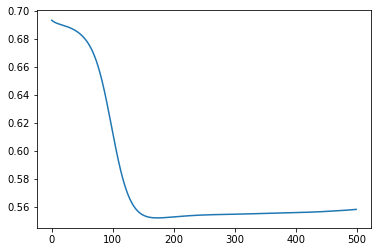

In [5]:
vl = np.load("experiments/GC/GFLAPPNP/biased_grad/I10/vl_0.npy")
plt.plot(vl)

In [6]:
file_to_open= open("experiments/GC/data/"+"csbm_"+str(0)+".pickle", "rb")
csbm = pickle.load(file_to_open)
file_to_open.close()
init_mlp = MLP(csbm.Xs[0].shape[1], 64, 2, bias=False)
A_tilde = calculate_Atilde(csbm.A, K=10, alpha=0.9)
server = set_up_GC(csbm.Xs, csbm.ys, init_mlp, A_tilde, n_train=60, n_val=20, improved=True)

In [17]:
server.eval_test()

(tensor(0.0838), 0.6864999999999999)

In [16]:
tl, ta, vl, va = train_GC(server, num_communication=100, batch_size=60, learning_rate=1, I=10,
                          gradient=True, noise=False, 
                          Print=True, print_time=1)

Communication: 1 Average train loss: 0.09219 Average train accuracy: 0.703 Average val loss: 0.09544 Average val accuracy: 0.686
Communication: 2 Average train loss: 0.08923 Average train accuracy: 0.703 Average val loss: 0.09243 Average val accuracy: 0.685
Communication: 3 Average train loss: 0.08651 Average train accuracy: 0.703 Average val loss: 0.08965 Average val accuracy: 0.686
Communication: 4 Average train loss: 0.08400 Average train accuracy: 0.704 Average val loss: 0.08710 Average val accuracy: 0.687
Communication: 5 Average train loss: 0.08168 Average train accuracy: 0.703 Average val loss: 0.08474 Average val accuracy: 0.687
Communication: 6 Average train loss: 0.07953 Average train accuracy: 0.703 Average val loss: 0.08256 Average val accuracy: 0.686


[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
for ith in range(20):
    for I in [10, 20, 50]:
        file_to_open= open("experiments/GC/data/"+"csbm_"+str(ith)+".pickle", "rb")
        csbm = pickle.load(file_to_open)
        file_to_open.close()
        nc = int(5000/I)
        exp_csbm(ith=ith, method="GFLAPPNP/", folder_path="experiments/GC/", csbm=csbm, n_train=60, n_val=20, 
                 num_communication=nc, batch_size=30,
                 learning_rate=0.1, I=I, gradient=True, noise=False,
                 Print=True, print_time=10,
                 resume=False,
                 bias=False,
                 save=True)
        print (ith, I)